## Problem statement:

More information about features: 

   1.  https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008
   2. https://www.hindawi.com/journals/bmri/2014/781670/
   3. Features formation: https://www.hindawi.com/journals/bmri/2014/781670/tab1/


So this week we have a problem coming to us from the medical community. We're looking specifically at a diabetes study. And the problem is hospital readmission.

Now we don't want people in hospitals. We want them to be well. And we certainly don't want them to be readmitted. This comes at a huge cost to the patient in terms of bills, lost wages, strain on their family and whatnot. So our goal is no readmission.


***Predict readmission of the patient within 30 days of initial hospitalization.***


Import libraries 

In [136]:
#for data
import pandas as pd 
import numpy as np 

# scikit-learn's SimpleImputer to replace "nan" values
from sklearn.impute import SimpleImputer

# Display all columns 
pd.options.display.max_columns = None
## for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from yellowbrick.classifier import ClassificationReport

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")
import time

#### Common Functions

In [137]:
#This funtion will group Diagnostic columns into CD-9-CM Chapters Code Range
#Ref:https://icd.codes/icd9cm
def groupDiagnosticColumns(df_full, diagnostic_column_name):
    df_temp = df_full
    df_temp[diagnostic_column_name] = df_full[diagnostic_column_name].str.replace('V','1000')
    df_temp[diagnostic_column_name] = df_temp[diagnostic_column_name].str.replace('E','1000')
    df_temp[diagnostic_column_name] = df_temp[diagnostic_column_name].astype(str).astype(float)
    cut_bins =[1, 139, 239, 279, 289, 319, 389, 459, 519, 579, 629, 679, 709, 739,759, 779, 799, 999, 100091, 2000999]
    cut_diagnose_code_range = ['001-139', '140-239', '240-279', '280-289', '290-319', '320-389', '390-459', '460-519', '520-579', '580-629', '630-679', '680-709', '710-739', '740-759', '760-779', '780-799', '800-999', 'V01-V91', 'E000-E999']
    df_full[diagnostic_column_name + '_Cat'] = pd.cut(df_temp[diagnostic_column_name], bins=cut_bins, labels = cut_diagnose_code_range)

    
def categorical_explanatory_binary_response_chart(chart_df, field, target, toggle=False, ):
    # the toggle switches which class is the "baseline" of the line chart
    drop_index = 2
    if toggle:
        drop_index = 1
    
    field_count  = chart_df[field].value_counts()
    field_count_df = field_count.to_frame()
    field_count_df.columns = ['count']
    
    field_target_pct = pd.crosstab(chart_df[field], chart_df[target], normalize='index') * 100
    field_target_pct = field_target_pct.reset_index()
    field_target_pct = field_target_pct.drop(field_target_pct.columns[-drop_index],axis=1)
    
    field_target_data = field_target_pct.merge(field_count_df, right_index=True, left_on=field).sort_values('count', ascending=False).reset_index(drop=True)
    
    print(field_target_data)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_xlabel(field)
    ax = sns.barplot(field_target_data[field], field_target_data['count'], alpha=0.8)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set_ylabel('count (bars)')
    ax2 = ax.twinx()
    ax2 = sns.pointplot(x=field_target_data[field], y=field_target_data.iloc[:, -2], color='black', legend=False)
    ax2.set_ylabel('% {t} (line)'.format(t = target))
    plt.show()

# this feature will impute the some of missing data features
def impute_Features(feature_name, df_impute):
    fill_nan_payer = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
    df_impute[feature_name] = fill_nan_payer.fit_transform(df_impute.loc[:,feature_name].values)
    
    
# This function creates dummy encodings from a lsit of features of interest and returns a dataframe     
def create_dummy_encod(df_encoding, features_of_interest, drop_first_cat=True, sparsity=True): 
    tmp_cont = []
    df_data_copy = df_encoding.copy()
    for feat in features_of_interest: 
        tmp_df = pd.get_dummies(df_data_copy[feat],prefix=str(feat),sparse=sparsity,drop_first=drop_first_cat)
        tmp_cont.append(tmp_df)
        feat_df = pd.concat(tmp_cont,axis=1)
        df_encoding = pd.concat([df_data_copy,feat_df], axis=1)
        df_encoding = df_encoding.drop(columns = features_of_interest, axis = 1)
    return df_encoding

cv = model_selection.StratifiedKFold(n_splits=5,shuffle=True, random_state=1234)

def stratified_cross_validate(model, X, y, cv=cv):
    start = time.time()
    cv_results = model_selection.cross_validate(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
    elapsed_time = (time.time() - start) 
    print ('Fold Scores:')
    print(' ')
    print(cv_results['test_score'])
    print(' ')
    print('Mean Accuracy: ', cv_results['test_score'].mean())
    print('Mean Fit Time: ', cv_results['fit_time'].mean())
    print('Mean Score Time: ', cv_results['score_time'].mean())
    print('CV Time: ', elapsed_time)
    return

# this will impute the columns with mode
def grouper_impute(df_Impute): 
    f = lambda x: x.mode().iloc[0]
    df_Impute = df_Impute.fillna(df_Impute.groupby('AgeGroup').transform(f))
    return df_Impute

def plot_class_dist(y, target_label = None):
    fig, axarr = plt.subplots(1, 2, figsize=(18, 6))
    class_ct = len(np.unique(y))
    vc = pd.value_counts(y)
    print('Total Records', len(y))
    print('Total Classes:', class_ct)
    print('Class Gini Index', gini_index(y))
    print('Smallest Class Id:',vc.idxmin(),'Records:',vc.min())
    print('Largest Class Id:',vc.idxmax(),'Records:',vc.max())
    print('Accuracy when Guessing:', np.round( (1 / len(np.unique(y))) * 100, 2), '%')

    sns.distplot(y, ax=axarr[0], bins=class_ct).set_title('Target Class Distribution:', target_label);
    sns.distplot(y, ax=axarr[1], kde=False, bins=class_ct).set_title('Target Class Counts:', target_label);

def gini_index(y):
    probs = pd.value_counts(y,normalize=True)
    return 1 - np.sum(np.square(probs))

def plot_confusion_matrix(y_test, y_hat):
    cm=metrics.confusion_matrix(y_test, y_hat)
    cm/np.sum(cm)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{var1}\n{var2}\n{var3}" for var1,var2,var3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure(figsize=(7,5))

    sns.heatmap(cm,
                annot=labels,
                fmt='',
                cmap='coolwarm',
                xticklabels=['Negative or 0','Positive or 1'],
                yticklabels=['Negative or 0','Positive or 1'],
                annot_kws={'size':16})

    plt.title('Confusion Matrix')
    plt.show()
    
def plot_roc_curve(y_test, y_hat):
    rf_roc_auc = metrics.roc_auc_score(y_test,y_hat)
    print('LR ROC:',rf_roc_auc)
    # plot the ROC curve from logistic regression
    logit_roc_auc = metrics.roc_auc_score(y_test, y_hat)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_hat)
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'b--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

### Data Preparation

#### Import Dataset 

In [138]:
df = pd.read_csv('https://raw.githubusercontent.com/rajeshsk/QTW/main/CaseStudy2/data/diabetic_data.csv')

In [139]:
metadata=pd.read_csv('https://raw.githubusercontent.com/rajeshsk/QTW/main/CaseStudy2/data/IDs_mapping.csv')
feature_desc = pd.read_csv('https://raw.githubusercontent.com/rajeshsk/QTW/main/CaseStudy2/data/features_descriptions.csv')

In [140]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


#### Define and preparing class variables.

 #### Clean the Dataset 

In [141]:
# Map admission_type_id to its appropriate name 
df['admission_type_id'] = df['admission_type_id'].map({1:'Emergency',
                                 2:'Urgent',
                                 3:'Elective',
                                 4:'Newborn',
                                 5:'Not Available',
                                 6:'NULL',
                                 7:'Trauma Center',
                                 8:'Not Mapped'})

In [142]:
# Replace all ? with NaN
df.loc[df['weight']=='?','weight'] = np.nan
df.loc[df['diag_1']=='?','diag_1'] = np.nan 
df.loc[df['diag_2']=='?','diag_2'] = np.nan 
df.loc[df['diag_3']=='?','diag_3'] = np.nan 
df.loc[df['age']=='?','age'] == np.nan
df.loc[df['payer_code']=='?','payer_code'] = np.nan
df.loc[df['medical_specialty']=='?','medical_specialty'] = np.nan
df.loc[df['race']=='?','race'] = np.nan
df.loc[df['weight']=='?','weight']=np.nan

# Remove characters between age 
df['age'] = df['age'].str.strip('[)')
df['weight'] = df['weight'].str.strip('[)')

# there are 3 instances with unknown gender. Replaced with mode 
df['gender']=df['gender'].replace('Unknown/Invalid','Female')

# Replacing all Not available, Not mapped, Null with eighter Unknown or NaN
df['max_glu_serum'] = df['max_glu_serum'].map({'>200':'diabetic',
                                               '>300':'critical high',
                                               'None':'unknown',
                                               'Norm':'Normal'})
df['admission_type_id'] = df['admission_type_id'].replace('Not Available','Unknown')

df.loc[df['admission_type_id']=='NULL','admission_type_id'] = np.nan
df.loc[df['admission_type_id']=='Not Mapped','admission_type_id'] = np.nan

df = df.rename(columns={'change':'diabetic_medication_change'}) 

In [143]:
df.shape

(101766, 50)

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   encounter_id                101766 non-null  int64 
 1   patient_nbr                 101766 non-null  int64 
 2   race                        99493 non-null   object
 3   gender                      101766 non-null  object
 4   age                         101766 non-null  object
 5   weight                      3197 non-null    object
 6   admission_type_id           96155 non-null   object
 7   discharge_disposition_id    101766 non-null  int64 
 8   admission_source_id         101766 non-null  int64 
 9   time_in_hospital            101766 non-null  int64 
 10  payer_code                  61510 non-null   object
 11  medical_specialty           51817 non-null   object
 12  num_lab_procedures          101766 non-null  int64 
 13  num_procedures              1

In [145]:
feature_desc = feature_desc[1:]

feature_name =feature_desc['Feature name']
feature_description = feature_desc['Description and values']

for f,d in zip(feature_name,feature_description):
    print()
    print(f,'-->',d)


Encounter ID --> Unique identifier of an encounter

Patient number --> Unique identifier of a patient

Race --> Values: Caucasian, Asian, African American, Hispanic, and other

Gender --> Values: male, female, and unknown/invalid

Age --> Grouped in 10-year intervals: 0, 10), 10, 20), …, 90, 100)

Weight --> Weight in pounds.

Admission type --> Integer identifier corresponding to 9 distinct values, for example, emergency, urgent, elective, newborn, and not available

Discharge disposition --> Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available

Admission source --> Integer identifier corresponding to 21 distinct values, for example, physician referral, emergency room, and transfer from a hospital

Time in hospital --> Integer number of days between admission and discharge

Payer code --> Integer identifier corresponding to 23 distinct values, for example, Blue Cross/Blue Shield, Medicare, and self-pay

Medical specialty 

In [146]:
df.describe(include=['object'])

,race,gender,age,weight,admission_type_id,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,diabetic_medication_change,diabetesMed,readmitted
count,99493,101766,101766,3197,96155,61510,51817,101745,101408,100343,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,5,2,10,9,6,17,72,716,748,789,4,4,4,4,4,4,4,2,4,4,2,4,4,4,4,2,3,1,1,4,4,2,2,2,2,2,2,3
top,Caucasian,Female,70-80,75-100,Emergency,MC,InternalMedicine,428,276,250,unknown,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
freq,76099,54711,26068,1336,53990,32439,14635,6862,6752,11555,96420,84748,81778,100227,101063,101680,96575,101765,89080,91116,101743,94438,95401,101458,101728,101763,101727,101766,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864


#### Dropping Encounter ID and Patient Number as it won't contribute towards the Clasisfication Model
#### Dropping Weight column because 97% data is missing

In [147]:
# Drop unnecessary columns 
df = df.drop(['encounter_id','patient_nbr','weight'],axis=1)


 #### New Features / Feature Engineering

#### Creating new feature AgeGroup for better categorizing the 'age' feature

In [148]:
# Create new feature AgeGroup
df['AgeGroup'] = df['age'].map({
                         '0-10':'child',
                        '10-20':'young adult',
                        '20-30':'twenties',
                        '30-40':'thirties',
                        '40-50':'fourties',
                        '50-60':'fifties',
                        '60-70':'sixties',
                        '70-80':'seventies',
                        '80-90':'eighties',
                        '90-100':'nineties'})

#### Dropping age after creating AgeGroup

In [149]:
# Drop more unuseful features 
df = df.drop(['age'],axis=1) # Drop age because we have AgeGroup.

In [150]:
df['A1Cresult'].unique()

array(['None', '>7', '>8', 'Norm'], dtype=object)

In [151]:
# https://www.singlecare.com/blog/normal-a1c-levels/
# Aic level general guidelines

df['A1Cresult']=df['A1Cresult'].map({'>7':'uncontrolled diabetes','>8':'critical high','Norm':'Normal','None':'Unknown'})

In [152]:
df['discharge_disposition_id'].unique()

array([25,  1,  3,  6,  2,  5, 11,  7, 10,  4, 14, 18,  8, 13, 12, 16, 17,
       22, 23,  9, 20, 15, 24, 28, 19, 27], dtype=int64)

In [153]:
# Get actual name of discharge_disposition_id and its id number into dataframe 
discharge_disposition_id_map=metadata[10:40]
discharge_disposition_id_map = discharge_disposition_id_map.rename(columns={'admission_type_id':'discharge_disposition_id'})

discharge_disposition_id_map = discharge_disposition_id_map.rename(columns={'description':'discharge_disposition_type'}) 

discharge_disposition_id_map['discharge_disposition_id'] = discharge_disposition_id_map['discharge_disposition_id'].astype(int)
#discharge_disposition_id_map

In [154]:
admission_source = metadata[42:69]
admission_source = admission_source.rename(columns={'description':'admission_source_type',
                                                   'admission_type_id':'admission_source_id'})
admission_source['admission_source_id'] = admission_source['admission_source_id'].astype(int)


In [155]:
# Merage df and discharge_disposition_id_map to get proper name of discharge_disposition_id 
df = pd.merge(df,discharge_disposition_id_map,on='discharge_disposition_id',how='left')

In [156]:
# Merger df and admission_source to map admission_source name to its ids 
df = pd.merge(df,admission_source,on='admission_source_id',how='left')

In [157]:
# Drop discharge_disposition_id and admission_source_id because we have AgeGroup.
df = df.drop(['discharge_disposition_id','admission_source_id'],axis=1)

In [158]:
df.head()

,race,gender,admission_type_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,diabetic_medication_change,diabetesMed,readmitted,AgeGroup,discharge_disposition_type,admission_source_type
0,Caucasian,Female,NaN,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,unknown,Unknown,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,child,Not Mapped,Physician Referral
1,Caucasian,Female,Emergency,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,unknown,Unknown,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30,young adult,Discharged to home,Emergency Room
2,AfricanAmerican,Female,Emergency,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,unknown,Unknown,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,twenties,Discharged to home,Emergency Room
3,Caucasian,Male,Emergency,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,unknown,Unknown,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO,thirties,Discharged to home,Emergency Room
4,Caucasian,Male,Emergency,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,unknown,Unknown,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO,fourties,Discharged to home,Emergency Room


#### These are all the categorical features

In [159]:
summary = df.describe(include='object')
print('Columns:',summary.columns)
summary

Columns: Index(['race', 'gender', 'admission_type_id', 'payer_code',
       'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum',
       'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'diabetic_medication_change', 'diabetesMed',
       'readmitted', 'AgeGroup', 'discharge_disposition_type',
       'admission_source_type'],
      dtype='object')


,race,gender,admission_type_id,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,diabetic_medication_change,diabetesMed,readmitted,AgeGroup,discharge_disposition_type,admission_source_type
count,99493,101766,96155,61510,51817,101745,101408,100343,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,98075,94985
unique,5,2,6,17,72,716,748,789,4,4,4,4,4,4,4,2,4,4,2,4,4,4,4,2,3,1,1,4,4,2,2,2,2,2,2,3,10,25,16
top,Caucasian,Female,Emergency,MC,InternalMedicine,428,276,250,unknown,Unknown,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,seventies,Discharged to home,Emergency Room
freq,76099,54711,53990,32439,14635,6862,6752,11555,96420,84748,81778,100227,101063,101680,96575,101765,89080,91116,101743,94438,95401,101458,101728,101763,101727,101766,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864,26068,60234,57494


#### Find all columns with NA values

In [160]:
# Find all columns with NA values
print('Features with missing data are:')
print()
for col in summary.columns:
    if summary.loc['count',col]!= df.shape[0]:
         print(col)
        

Features with missing data are:

race
admission_type_id
payer_code
medical_specialty
diag_1
diag_2
diag_3
discharge_disposition_type
admission_source_type


#### Check percentage of missing data 

In [161]:
# Check percentage of missing data 
df[['payer_code','medical_specialty','diag_1','diag_2','discharge_disposition_type','admission_source_type']].isna().sum()/df.shape[0]*100

payer_code                    39.557416
medical_specialty             49.082208
diag_1                         0.020636
diag_2                         0.351787
discharge_disposition_type     3.626948
admission_source_type          6.663326
dtype: float64

In [162]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 0 to 101765
Data columns (total 47 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   race                        99493 non-null   object
 1   gender                      101766 non-null  object
 2   admission_type_id           96155 non-null   object
 3   time_in_hospital            101766 non-null  int64 
 4   payer_code                  61510 non-null   object
 5   medical_specialty           51817 non-null   object
 6   num_lab_procedures          101766 non-null  int64 
 7   num_procedures              101766 non-null  int64 
 8   num_medications             101766 non-null  int64 
 9   number_outpatient           101766 non-null  int64 
 10  number_emergency            101766 non-null  int64 
 11  number_inpatient            101766 non-null  int64 
 12  diag_1                      101745 non-null  object
 13  diag_2                      1

## Define the statistical data types.

Define which features are numeric, nominal, ordinal, categorical and unwanted. 

<b>Numeric Discrete Features </b>

In [163]:
# loop over the column and get me only the col with int datatype
print('List Of Numeric Discrete are:')
[(col,dtype) for col,dtype in df.dtypes.items() if dtype =='int64']

List Of Numeric Discrete are:


[('time_in_hospital', dtype('int64')),
 ('num_lab_procedures', dtype('int64')),
 ('num_procedures', dtype('int64')),
 ('num_medications', dtype('int64')),
 ('number_outpatient', dtype('int64')),
 ('number_emergency', dtype('int64')),
 ('number_inpatient', dtype('int64')),
 ('number_diagnoses', dtype('int64'))]

<b>Categorical Features </b> 

In [164]:
print("List of Categorical Features: ")
print()
print([feature for feature,dtype in df.dtypes.items() if dtype=='object'])
    

List of Categorical Features: 

['race', 'gender', 'admission_type_id', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'diabetic_medication_change', 'diabetesMed', 'readmitted', 'AgeGroup', 'discharge_disposition_type', 'admission_source_type']


<b>Ordinal Features </b> 

Weight of these features will have impact on readmition. Hence, they should be ordinal instead of dummy code
    
        1. AgeGroup
        2. max_glu_serum
        3. ACresult
        

In [165]:
df['max_glu_serum'].value_counts() 

unknown          96420
Normal            2597
diabetic          1485
critical high     1264
Name: max_glu_serum, dtype: int64

In [166]:
df[['metformin']].value_counts()


metformin
No           81778
Steady       18346
Up            1067
Down           575
dtype: int64

In [167]:
df['repaglinide'].value_counts() 

No        100227
Steady      1384
Up           110
Down          45
Name: repaglinide, dtype: int64

#### Majority of the patients are females

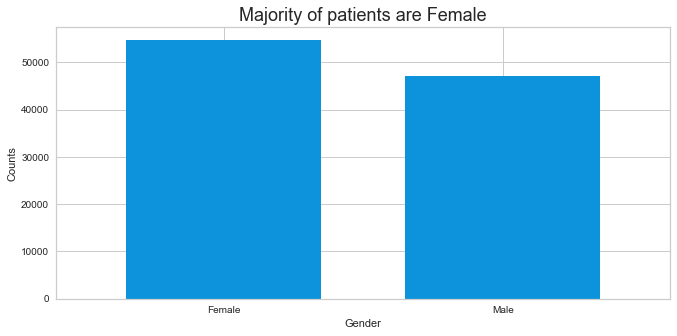

In [168]:
df['gender'].value_counts().plot(kind='bar',width=0.7,color='#0C93DB',figsize=(11,5),rot='horizontal')
plt.title('Majority of patients are Female',size=18)
plt.xlabel('Gender')
plt.ylabel('Counts')
plt.show()

#### Our goal is to predict if patient is going to be readmitted within 30 days. We will convert into 2 groups <30 days and remaining.

In [169]:
# Change all >30 and NO readmitted to NO 
df['readmitted'] = df['readmitted'].map({'NO':'NO','>30':'NO','<30':'YES'}) 

#### Targer feature 'readmitted' is very unbalanced

In [170]:
df['readmitted'].value_counts()

NO     90409
YES    11357
Name: readmitted, dtype: int64

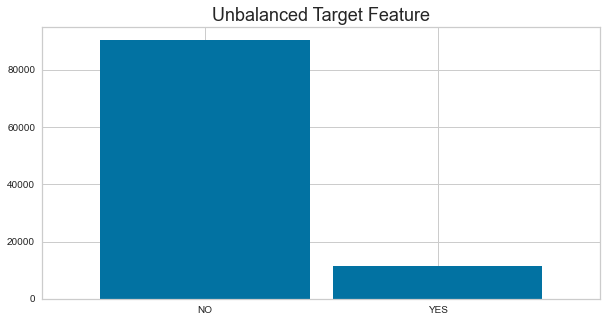

In [171]:
df['readmitted'].value_counts().plot(kind='bar',width=0.9,rot='horizontal',figsize=(10,5)) 
plt.title('Unbalanced Target Feature',size=18)
plt.show()

### EDA

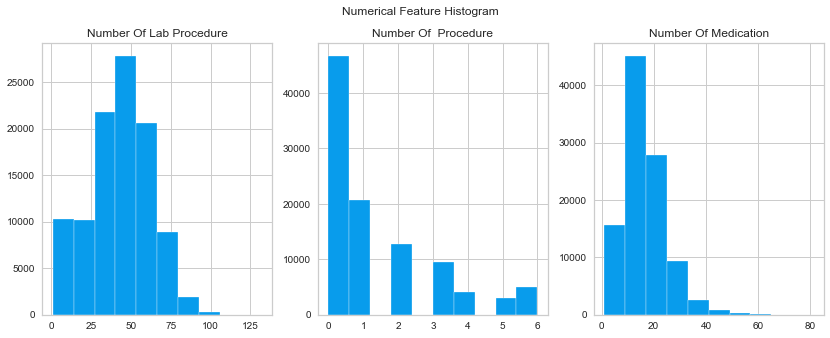

In [172]:
# Function that takes numerical data and create histogram 
fig,ax = plt.subplots(1,3,figsize=(14,5))

ax[0].hist(df['num_lab_procedures'],color='#089CEC',edgecolor='white') 
ax[0].set(title='Number Of Lab Procedure')
ax[1].hist(df['num_procedures'],color='#089CEC',edgecolor='white')
ax[1].set(title='Number Of  Procedure')
ax[2].hist(df['num_medications'],color='#089CEC',edgecolor='white')
ax[2].set(title='Number Of Medication')
plt.suptitle('Numerical Feature Histogram')
plt.show()

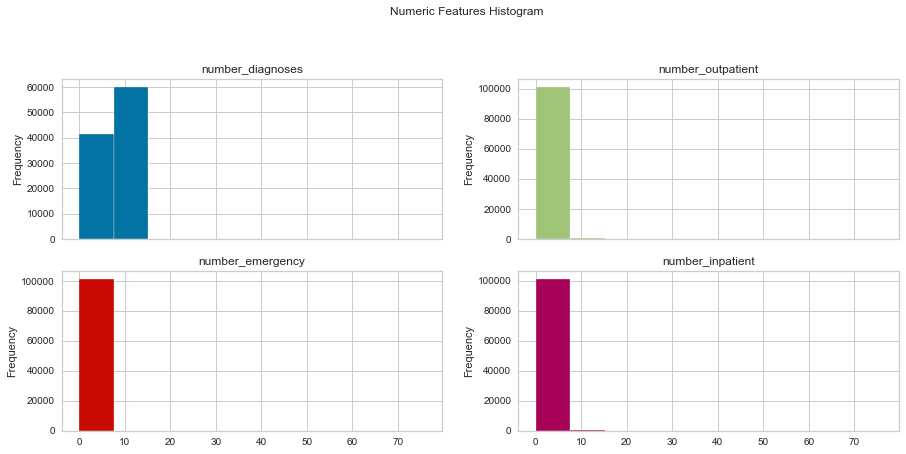

In [173]:
df.plot(kind='hist',y=['number_diagnoses','number_outpatient', 'number_emergency', 'number_inpatient'],
        edgecolor='white',figsize=[15,10],
        title=['number_diagnoses','number_outpatient', 'number_emergency', 'number_inpatient'],
        subplots=True,layout=(3,2),legend=False)
plt.suptitle('Numeric Features Histogram')
plt.show()

In [174]:
# encode target feature 
df['readmitted']=df['readmitted'].map({'YES':1,'NO':0}) 

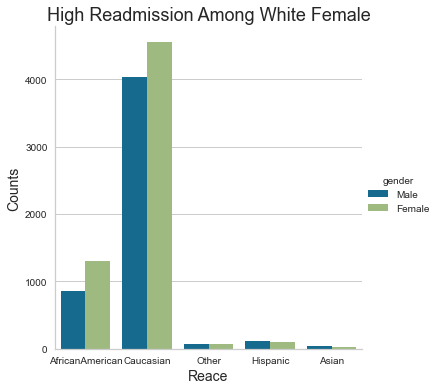

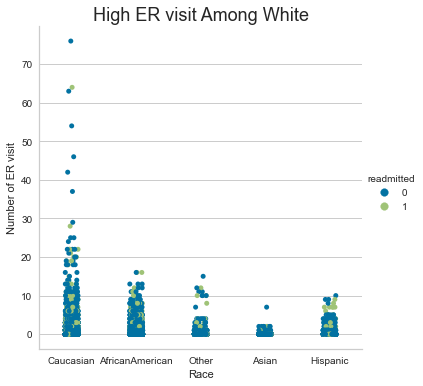

In [175]:
# Fix this plot 

# Among all the pepople who are readmitted what race and gender most likely to readmite

dat = df.loc[df['readmitted']==1,['race','gender']] 
#fig, ax = plt.subplots(1,2,figsize=(13,6))
sns.catplot(x='race',hue='gender',kind='count',data=dat,ax=ax[0])
plt.title('High Readmission Among White Female',size=18)
plt.xlabel('Reace',size=14)
plt.ylabel('Counts',size=14)
sns.catplot(x="race", y="number_emergency", hue="readmitted",  data=df,ax=ax[1])
plt.title('High ER visit Among White',size=18)
plt.xlabel('Race')
plt.ylabel('Number of ER visit')

plt.show()

In [176]:
#categorial_feature_count = len(categorical_features)
#plt.figure(figsize=(10, 6*categorial_feature_count))
#for feature in categorical_features:
#    categorical_explanatory_binary_response_chart(df, feature, 'readmitted')

### What age group people spends more time in the hospital among all readmitted patients ?

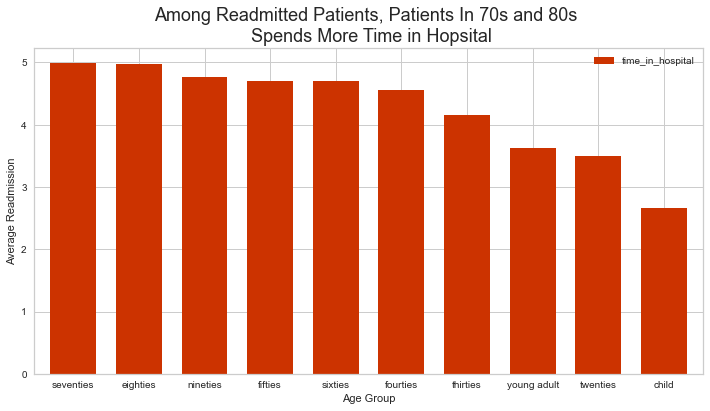

In [177]:

readmit_age= df.loc[df['readmitted']==1,['time_in_hospital','AgeGroup']].groupby(['AgeGroup']).mean()

readmit_age.sort_values(by='time_in_hospital',ascending=False).reset_index().plot(kind='bar',x='AgeGroup',
                                                                                  y='time_in_hospital',
                                                                                  figsize=(12,6),
                                                                                  width=.7,
                                                                                  rot='horizontal',
                                                                                  color='#cc3300')

plt.title('Among Readmitted Patients, Patients In 70s and 80s \n Spends More Time in Hopsital',size=18)
plt.ylabel('Average Readmission')
plt.xlabel('Age Group')
plt.show()


What is the distribution of time at hospital based on if readmission is YES or NO

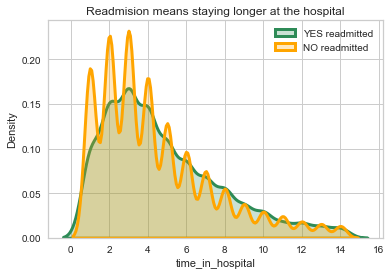

In [178]:
sns.distplot(df.loc[df['readmitted']==1,'time_in_hospital'],color='seagreen',hist=False,kde=True,
           kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = "YES readmitted") 
sns.distplot(df.loc[df['readmitted']==0,'time_in_hospital'],color='orange',hist=False,kde=True,
            kde_kws={'shade':True,'linewidth':3},label='NO readmitted') 
plt.legend() 
plt.title('Readmision means staying longer at the hospital')
plt.show() 

In [179]:
df.head(5) 

,race,gender,admission_type_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,diabetic_medication_change,diabetesMed,readmitted,AgeGroup,discharge_disposition_type,admission_source_type
0,Caucasian,Female,NaN,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,unknown,Unknown,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,child,Not Mapped,Physician Referral
1,Caucasian,Female,Emergency,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,unknown,Unknown,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0,young adult,Discharged to home,Emergency Room
2,AfricanAmerican,Female,Emergency,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,unknown,Unknown,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,0,twenties,Discharged to home,Emergency Room
3,Caucasian,Male,Emergency,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,unknown,Unknown,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0,thirties,Discharged to home,Emergency Room
4,Caucasian,Male,Emergency,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,unknown,Unknown,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0,fourties,Discharged to home,Emergency Room


#### Realation Of Readmission With admission source typea and admission type

Plot on the left shows that the patients is more likely to get readmitted again in less than 30 days if they are a 
transfer patients from hospital inpt/same fac reslt in a sep claaim. 
And the plot on the right shows that if a patient is ER patients they are more than likely to readmit again in less than 30 days 

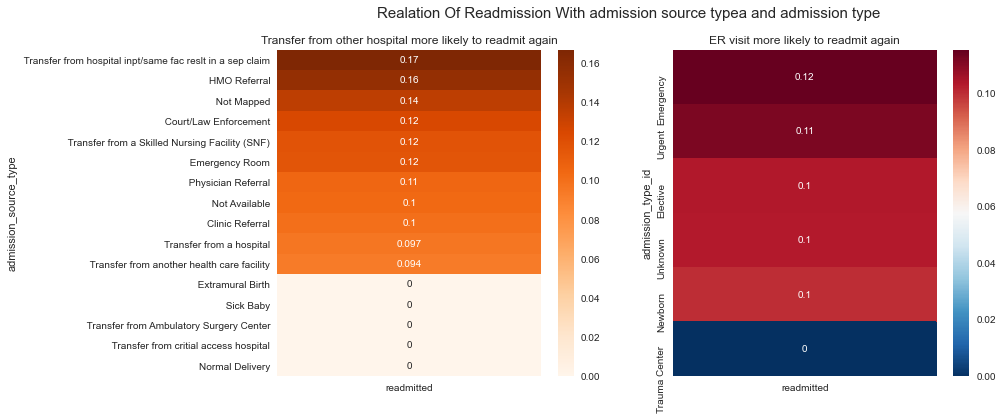

In [180]:
fig,ax = plt.subplots(1,2,figsize=(13,6))
sns.heatmap(df[['admission_source_type','readmitted']].groupby(by='admission_source_type').mean().sort_values(by='readmitted',ascending=False),annot=True,cmap='Oranges',ax=ax[0],label=False)
ax[0].set(title='Transfer from other hospital more likely to readmit again')
ax[1].set(title='ER visit more likely to readmit again')

sns.heatmap(df[['admission_type_id','readmitted']].groupby(by='admission_type_id').mean().sort_values(by='readmitted', ascending=False),annot=True,cmap='RdBu_r',ax=ax[1])
plt.suptitle('Realation Of Readmission With admission source typea and admission type',size=15)
plt.show()


Among patients who will not get readmited in less than 30 days, ***62.67%*** were discharged to their home 

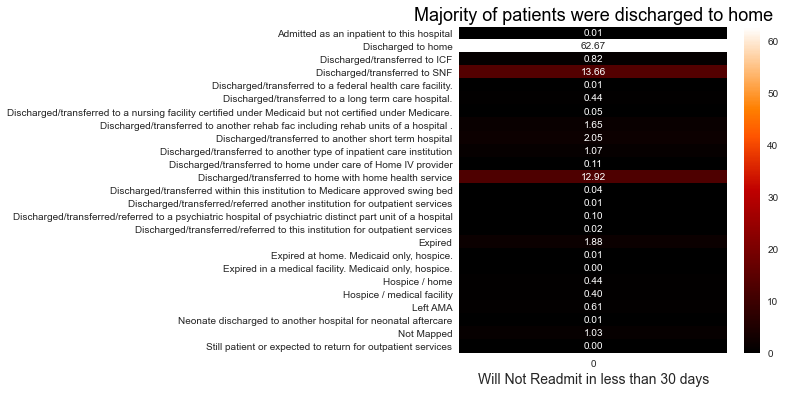

In [181]:
df_discharge = df.loc[df['readmitted']==0,['discharge_disposition_type','readmitted']]

ct = pd.crosstab(df_discharge['discharge_disposition_type'], 
                 df_discharge['readmitted'],
                    normalize=True ).round(4)*100 

plt.figure(figsize=(6,6))
discharge_readmit = sns.cubehelix_palette(start=0,light=1,as_cmap=True)
sns.heatmap(ct,annot=True,cmap='gist_heat',fmt='.2f',linewidths=.0)
plt.xlabel('Will Not Readmit in less than 30 days',size=14)
plt.ylabel('',size=14)
plt.title('Majority of patients were discharged to home',fontsize=18,color='black')
plt.show()

#### Correlation of numerical features 

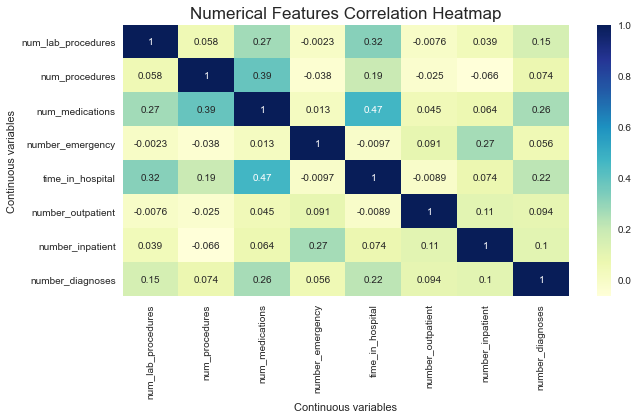

In [182]:
plt.figure(figsize=(10,5))
corr=df[['num_lab_procedures','num_procedures','num_medications','number_emergency','time_in_hospital','number_outpatient','number_inpatient','number_diagnoses']].corr()
sns.heatmap(corr, cmap="YlGnBu", annot=True)
plt.title("Correlation matrix", y=-0.75)
plt.xlabel("Continuous variables")
plt.ylabel("Continuous variables")
plt.title('Numerical Features Correlation Heatmap',size=17)
plt.show()


In [183]:
corr=df[['num_lab_procedures','num_procedures','num_medications','number_emergency','time_in_hospital','number_outpatient','number_inpatient','number_diagnoses']]
#sns.pairplot(data=corr, hue="readmitted")


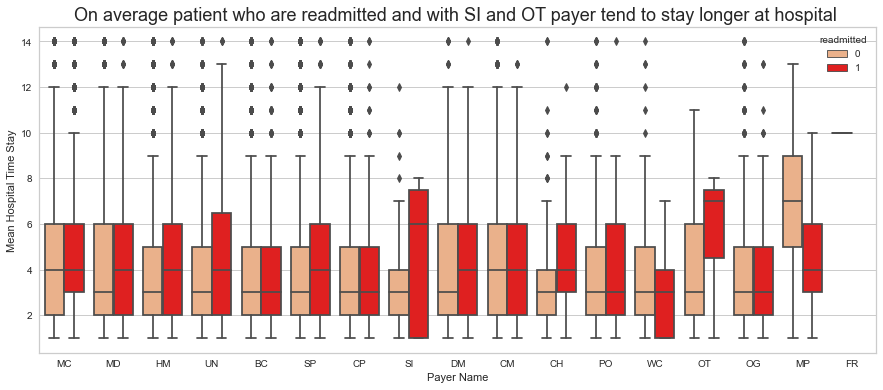

In [184]:
plt.figure(figsize=(15,6))
sns.boxplot(x=df['payer_code'],y=df['time_in_hospital'],hue=df['readmitted'],palette=["#FAAE7B",'red'])
plt.xlabel('Payer Name')
plt.ylabel('Mean Hospital Time Stay')
plt.title('On average patient who are readmitted and with SI and OT payer tend to stay longer at hospital ',size=18)
plt.show()

### Replacing all Not available, Not mapped, Null with eighter Unknown or NaN

In [185]:
# df['max_glu_serum'] = df['max_glu_serum'].map({'>200':'diabetic',
#                                                '>300':'critical high',
#                                                'None':'unknown',
#                                                'Norm':'Normal'})
# df['admission_type_id'] = df['admission_type_id'].replace('Not Available','Unknown')
# df.loc[df['admission_type_id']=='NULL','admission_type_id'] = np.nan
# df.loc[df['admission_type_id']=='Not Mapped','admission_type_id'] = np.nan
# df = df.rename(columns={'change':'diabetic_medication_change'}) 


#### Working with ICD9 code. Grouping Diagnostic columns with ICD-9-CM Chapters Code Range
###### Ref:https://icd.codes/icd9cm

In [186]:
#Create custom code range feature for diag_1, diag_2, diag_3 columns
groupDiagnosticColumns(df, 'diag_1')
groupDiagnosticColumns(df, 'diag_2')
groupDiagnosticColumns(df, 'diag_3')

In [187]:
df.head()

,race,gender,admission_type_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,diabetic_medication_change,diabetesMed,readmitted,AgeGroup,discharge_disposition_type,admission_source_type,diag_1_Cat,diag_2_Cat,diag_3_Cat
0,Caucasian,Female,NaN,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,unknown,Unknown,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0,child,Not Mapped,Physician Referral,240-279,NaN,NaN
1,Caucasian,Female,Emergency,3,NaN,NaN,59,0,18,0,0,0,276.00,250.01,255.0,9,unknown,Unknown,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0,young adult,Discharged to home,Emergency Room,240-279,240-279,240-279
2,AfricanAmerican,Female,Emergency,2,NaN,NaN,11,5,13,2,0,1,648.00,250.00,100027.0,6,unknown,Unknown,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,0,twenties,Discharged to home,Emergency Room,630-679,240-279,V01-V91
3,Caucasian,Male,Emergency,2,NaN,NaN,44,1,16,0,0,0,8.00,250.43,403.0,7,unknown,Unknown,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0,thirties,Discharged to home,Emergency Room,001-139,240-279,390-459
4,Caucasian,Male,Emergency,1,NaN,NaN,51,0,8,0,0,0,197.00,157.00,250.0,5,unknown,Unknown,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0,fourties,Discharged to home,Emergency Room,140-239,140-239,240-279


##### Dropping diag_1, diag_2, diag_3 as we have created range features

In [188]:
# Drop unnecessary columns 
df = df.drop(['diag_1','diag_2','diag_3'],axis=1)

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 0 to 101765
Data columns (total 47 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   race                        99493 non-null   object  
 1   gender                      101766 non-null  object  
 2   admission_type_id           96155 non-null   object  
 3   time_in_hospital            101766 non-null  int64   
 4   payer_code                  61510 non-null   object  
 5   medical_specialty           51817 non-null   object  
 6   num_lab_procedures          101766 non-null  int64   
 7   num_procedures              101766 non-null  int64   
 8   num_medications             101766 non-null  int64   
 9   number_outpatient           101766 non-null  int64   
 10  number_emergency            101766 non-null  int64   
 11  number_inpatient            101766 non-null  int64   
 12  number_diagnoses            101766 non-null  int64   
 13 

##### Imputing missing data 

In [190]:
df = grouper_impute(df)

In [191]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101766 entries, 0 to 101765
Data columns (total 47 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   race                        101766 non-null  object  
 1   gender                      101766 non-null  object  
 2   admission_type_id           101766 non-null  object  
 3   time_in_hospital            101766 non-null  int64   
 4   payer_code                  101766 non-null  object  
 5   medical_specialty           101766 non-null  object  
 6   num_lab_procedures          101766 non-null  int64   
 7   num_procedures              101766 non-null  int64   
 8   num_medications             101766 non-null  int64   
 9   number_outpatient           101766 non-null  int64   
 10  number_emergency            101766 non-null  int64   
 11  number_inpatient            101766 non-null  int64   
 12  number_diagnoses            101766 non-null  int64   
 13 

In [192]:
df.isna().sum()/df.shape[0]*100

race                          0.0
gender                        0.0
admission_type_id             0.0
time_in_hospital              0.0
payer_code                    0.0
medical_specialty             0.0
num_lab_procedures            0.0
num_procedures                0.0
num_medications               0.0
number_outpatient             0.0
number_emergency              0.0
number_inpatient              0.0
number_diagnoses              0.0
max_glu_serum                 0.0
A1Cresult                     0.0
metformin                     0.0
repaglinide                   0.0
nateglinide                   0.0
chlorpropamide                0.0
glimepiride                   0.0
acetohexamide                 0.0
glipizide                     0.0
glyburide                     0.0
tolbutamide                   0.0
pioglitazone                  0.0
rosiglitazone                 0.0
acarbose                      0.0
miglitol                      0.0
troglitazone                  0.0
tolazamide    

#### Dummy Code Variables 

#### These are the features which we want to dummy code

In [193]:
features_of_interest_encoding =['race', 'gender', 'admission_type_id', 'payer_code',
       'medical_specialty', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'diabetic_medication_change', 
       'diabetesMed', 'AgeGroup', 'discharge_disposition_type',
       'admission_source_type', 'diag_1_Cat', 'diag_2_Cat', 'diag_3_Cat']
print(features_of_interest_encoding)

['race', 'gender', 'admission_type_id', 'payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'diabetic_medication_change', 'diabetesMed', 'AgeGroup', 'discharge_disposition_type', 'admission_source_type', 'diag_1_Cat', 'diag_2_Cat', 'diag_3_Cat']


In [194]:
df_dummy_enc = create_dummy_encod(df, features_of_interest_encoding, drop_first_cat=True, sparsity=True)

In [195]:
df_dummy_enc.shape

(101766, 264)

In [196]:
df_dummy_enc.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,readmitted,race_Asian,race_Caucasian,race_Hispanic,race_Other,gender_Male,admission_type_id_Emergency,admission_type_id_Newborn,admission_type_id_Trauma Center,admission_type_id_Unknown,admission_type_id_Urgent,payer_code_CH,payer_code_CM,payer_code_CP,payer_code_DM,payer_code_FR,payer_code_HM,payer_code_MC,payer_code_MD,payer_code_MP,payer_code_OG,payer_code_OT,payer_code_PO,payer_code_SI,payer_code_SP,payer_code_UN,payer_code_WC,medical_specialty_Anesthesiology,medical_specialty_Anesthesiology-Pediatric,medical_specialty_Cardiology,medical_specialty_Cardiology-Pediatric,medical_specialty_DCPTEAM,medical_specialty_Dentistry,medical_specialty_Dermatology,medical_specialty_Emergency/Trauma,medical_specialty_Endocrinology,medical_specialty_Endocrinology-Metabolism,medical_specialty_Family/GeneralPractice,medical_specialty_Gastroenterology,medical_specialty_Gynecology,medical_specialty_Hematology,medical_specialty_Hematology/Oncology,medical_specialty_Hospitalist,medical_specialty_InfectiousDiseases,medical_specialty_InternalMedicine,medical_specialty_Nephrology,medical_specialty_Neurology,medical_specialty_Neurophysiology,medical_specialty_Obsterics&Gynecology-GynecologicOnco,medical_specialty_Obstetrics,medical_specialty_ObstetricsandGynecology,medical_specialty_Oncology,medical_specialty_Ophthalmology,medical_specialty_Orthopedics,medical_specialty_Orthopedics-Reconstructive,medical_specialty_Osteopath,medical_specialty_Otolaryngology,medical_specialty_OutreachServices,medical_specialty_Pathology,medical_specialty_Pediatrics,medical_specialty_Pediatrics-AllergyandImmunology,medical_specialty_Pediatrics-CriticalCare,medical_specialty_Pediatrics-EmergencyMedicine,medical_specialty_Pediatrics-Endocrinology,medical_specialty_Pediatrics-Hematology-Oncology,medical_specialty_Pediatrics-InfectiousDiseases,medical_specialty_Pediatrics-Neurology,medical_specialty_Pediatrics-Pulmonology,medical_specialty_Perinatology,medical_specialty_PhysicalMedicineandRehabilitation,medical_specialty_PhysicianNotFound,medical_specialty_Podiatry,medical_specialty_Proctology,medical_specialty_Psychiatry,medical_specialty_Psychiatry-Addictive,medical_specialty_Psychiatry-Child/Adolescent,medical_specialty_Psychology,medical_specialty_Pulmonology,medical_specialty_Radiologist,medical_specialty_Radiology,medical_specialty_Resident,medical_specialty_Rheumatology,medical_specialty_Speech,medical_specialty_SportsMedicine,medical_specialty_Surgeon,medical_specialty_Surgery-Cardiovascular,medical_specialty_Surgery-Cardiovascular/Thoracic,medical_specialty_Surgery-Colon&Rectal,medical_specialty_Surgery-General,medical_specialty_Surgery-Maxillofacial,medical_specialty_Surgery-Neuro,medical_specialty_Surgery-Pediatric,medical_specialty_Surgery-Plastic,medical_specialty_Surgery-PlasticwithinHeadandNeck,medical_specialty_Surgery-Thoracic,medical_specialty_Surgery-Vascular,medical_specialty_SurgicalSpecialty,medical_specialty_Urology,max_glu_serum_critical high,max_glu_serum_diabetic,max_glu_serum_unknown,A1Cresult_Unknown,A1Cresult_critical high,A1Cresult_uncontrolled diabetes,metformin_No,metformin_Steady,metformin_Up,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_No,chlorpropamide_Steady,chlorpropamide_Up,glimepiride_No,glimepiride_Steady,glimepiride_Up,acetohexamide_Steady,glipizide_No,glipizide_Steady,glipizide_Up,glyburide_No,glyburide_Steady,glyburide_Up,tolbutamide_Steady,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,acarbose_No,acarbose_Steady,acarbose_Up,miglitol_No,miglitol_Steady,miglitol_Up,troglitazone_Steady,tolazamide_Steady,tolazamide_Up,insulin_No,insulin_Steady,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_Steady,glimepiride-pioglit

#### Scale the Numerical Variables 

#### Get the final dataset ready to model 

#### Split datasets into training and testing 

In [201]:
y = df_dummy_enc['readmitted']
X = df_dummy_enc.drop(columns = ['readmitted'], axis = 1)

<br>

In [202]:
# Break our data into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1234, stratify=y)

### Logistic Regression Iteration 1 - Unscaled Data¶

We will use 5-fold cross validation to determine a baseline accuracy score for logistic regression.

In [204]:
#https://nbviewer.jupyter.org/github/jakemdrew/MachineLearningExtras/blob/master/LFW%20Dataset%20and%20Class%20Imbalance.ipynb
cv = model_selection.StratifiedKFold(n_splits=5,shuffle=True, random_state=1234)
model = linear_model.LogisticRegression(solver='lbfgs', random_state=1234, max_iter = 1e3)
stratified_cross_validate(model, X_train, y_train, cv=cv)

Fold Scores:
 
[0.8882884  0.8878585  0.88809729 0.88785162 0.88877288]
 
Mean Accuracy:  0.8881737360655733
Mean Fit Time:  55.01447587013244
Mean Score Time:  0.08199515342712402
CV Time:  59.655269622802734


<font style="color:#7B1FA2;font-weight:600">We will use 88.80 % as our baseline accuracy for logistic regression. Let's see how scaling the data can help increase our accuracy.</font>

#### Let us fit the predict the accuracy of the model

In [206]:
model.fit(X_train, y_train)
y_model_predict = model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_model_predict)
print('Accuracy of "Logistic Regression Iteration 1 - Unscaled Data": ', accuracy)

Accuracy of "Logistic Regression Iteration 1 - Unscaled Data":  0.8877861845337526


<font style="color:#ff0000;font-weight:600">Prediction accuracy for Logistic Regression Iteration 1 - unscaled Data is 88.77 % </font>

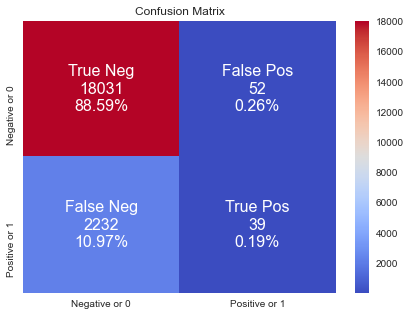

In [207]:
plot_confusion_matrix(y_test, y_model_predict)

LR ROC: 0.5071487112376506


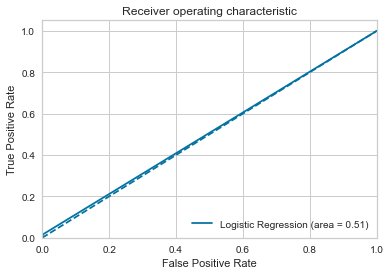

In [208]:
plot_roc_curve(y_test, y_model_predict)

<br/><br/>

### Logistic Regression Iteration 2 - Scaled data

In [209]:
#Scaling the features will likely make a big improvement to accuaracy 
#Scaling the entire data before split for cross validation
std_scalar = preprocessing.StandardScaler()
X_scaled = std_scalar.fit_transform(X)

# Resetting the split data after scaling
# Break our data into 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=1234, stratify=y)

#### Next, we will run the model using 5-fold cross validation on scaled data.

In [210]:
cv_scaled = model_selection.StratifiedKFold(n_splits=5,shuffle=True, random_state=1234)
model_scaled = linear_model.LogisticRegression(solver='lbfgs', random_state=1234, max_iter = 1e3)
stratified_cross_validate(model_scaled, X_train, y_train, cv=cv_scaled)

Fold Scores:
 
[0.88822699 0.88755143 0.88791303 0.8877902  0.88858863]
 
Mean Accuracy:  0.8880140550495123
Mean Fit Time:  10.819549322128296
Mean Score Time:  0.01199965476989746
CV Time:  13.145018577575684


<font style="color:#7B1FA2;font-weight:600">Accuracy remain same but Fit time decreased from 55.15 seconds to 11 seconds, Score time reduced from 0.020 to 0.015  and CV time decreased from 56 seconds to 15 seconds.</font>

In [211]:
model_scaled.fit(X_train, y_train)
y_model_scaled_predict = model_scaled.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_model_scaled_predict)
print('Accuracy of "Logistic Regression Iteration 2 - scaled Data": ', accuracy)

Accuracy of "Logistic Regression Iteration 2 - scaled Data":  0.887737054141692


<font style="color:#ff0000;font-weight:600">Prediction accuracy for Logistic Regression Iteration 2 - scaled Data is 88.77 % </font>

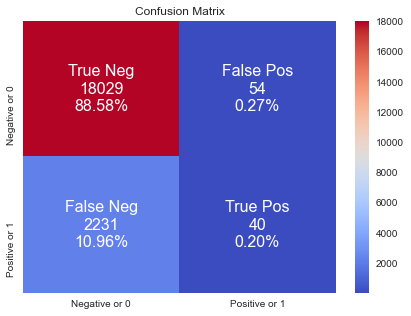

In [212]:
plot_confusion_matrix(y_test, y_model_scaled_predict)

LR ROC: 0.5073135780062836


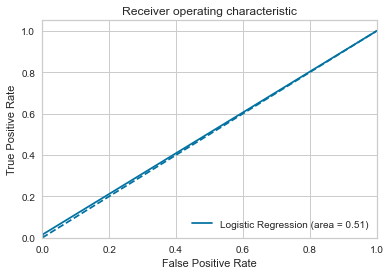

In [213]:
plot_roc_curve(y_test, y_model_scaled_predict)

<br/><br/>

### Logistic Regression Iteration 3 - Penalty L2 and scaled

In [214]:
model_scaled_l2 = linear_model.LogisticRegressionCV(penalty="l2", solver='lbfgs', random_state=1234, cv=5)
model_scaled_l2 = model_scaled_l2_balanced.fit(X_train, y_train)

In [215]:
model_scaled_l2.score(X_train, y_train)

0.671805139291505

In [216]:
model_scaled_l2.scores_

{1: array([[0.66885709],
        [0.66640054],
        [0.6725218 ],
        [0.66631863],
        [0.66914384]])}

In [217]:
model_scaled_l2.C_

array([0.00077426])

<font style="color:#7B1FA2;font-weight:600">Best C is 0.0001</font>

In [218]:
y_model_scaled_l2_predict = model_scaled_l2.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_model_scaled_l2_predict)
print('Logistic Regression Iteration 3 - Penalty L2 and scaled and balanced": ', accuracy)

Logistic Regression Iteration 3 - Penalty L2 and scaled and balanced":  0.6713668075071239


<font style="color:#ff0000;font-weight:600">Prediction accuracy for Logistic Regression Iteration 3 - Penalty L2 and scaled Data is 88.83 % </font>

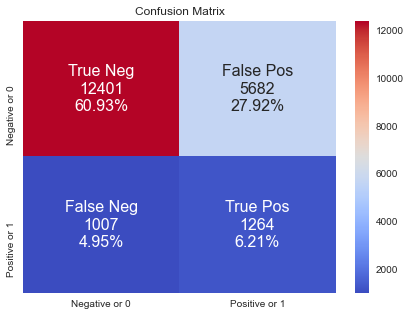

In [219]:
plot_confusion_matrix(y_test, y_model_scaled_l2_balanced_predict)

LR ROC: 0.6211826147414147


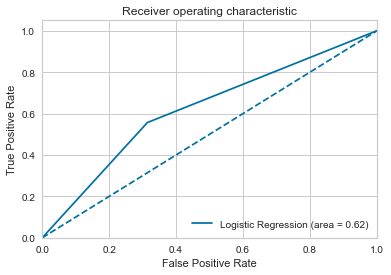

In [220]:
plot_roc_curve(y_test, y_model_scaled_l2_balanced_predict)

<br/><br/>

### Logistic Regression Iteration 4 - Penalty L2 and scaled and balanced

In [221]:
model_scaled_l2_balanced = linear_model.LogisticRegressionCV(penalty="l2", solver='lbfgs', 
                                                             random_state=1234, cv=5, class_weight='balanced')
model_scaled_l2_balanced = model_scaled_l2_balanced.fit(X_train, y_train)

In [222]:
model_scaled_l2_balanced.score(X_train, y_train)

0.671805139291505

In [223]:
model_scaled_l2_balanced.scores_

{1: array([[0.66947123, 0.66885709, 0.66658478, 0.66603206, 0.66584782,
         0.66597064, 0.66615489, 0.66615489, 0.66597064, 0.66603206],
        [0.66468096, 0.66640054, 0.66584782, 0.66480378, 0.6648652 ,
         0.66455813, 0.66461954, 0.66455813, 0.66455813, 0.66455813],
        [0.67436433, 0.6725218 , 0.67049503, 0.67092495, 0.67135487,
         0.67172338, 0.67129345, 0.67129345, 0.67123204, 0.67123204],
        [0.66380052, 0.66631863, 0.66459894, 0.66380052, 0.66349343,
         0.66398477, 0.66392335, 0.66380052, 0.66367768, 0.66367768],
        [0.66595013, 0.66914384, 0.66895959, 0.66859108, 0.66803832,
         0.66797691, 0.66791549, 0.66809974, 0.66803832, 0.66803832]])}

In [224]:
model_scaled_l2_balanced.C_

array([0.00077426])

#### Best C is 0.00077426

In [225]:
model_scaled_l2_balanced = linear_model.LogisticRegressionCV(Cs=[0.00077426], penalty="l2", solver='lbfgs', 
                                                             random_state=1234, cv=5, class_weight='balanced')
model_scaled_l2_balanced = model_scaled_l2_balanced.fit(X_train, y_train)

In [226]:
y_model_scaled_l2_balanced_predict = model_scaled_l2_balanced.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_model_scaled_l2_balanced_predict)
print('Logistic Regression Iteration 4 - Penalty L2 and scaled and balanced": ', accuracy)

Logistic Regression Iteration 4 - Penalty L2 and scaled and balanced":  0.6713668075071239


<font style="color:#ff0000;font-weight:600">Prediction accuracy for Logistic Regression Iteration 4 - Penalty L2 and scaled and balanced Data is 67.14 % </font>

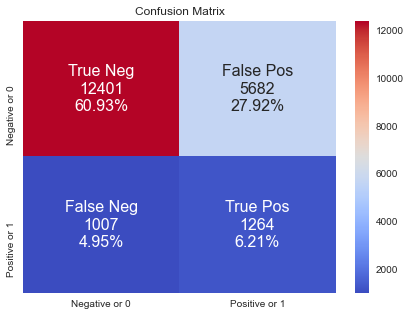

In [227]:
plot_confusion_matrix(y_test, y_model_scaled_l2_balanced_predict)

LR ROC: 0.6211826147414147


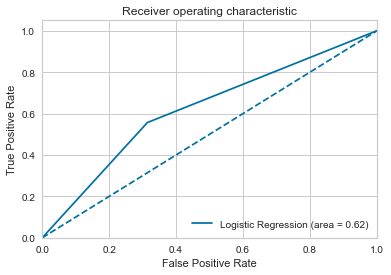

In [228]:
plot_roc_curve(y_test, y_model_scaled_l2_balanced_predict)

<br/><br/>

### Logistic Regression Iteration 5 - Penalty L2, scaled and upsampled using SMOTE

#### Using imblearn.over_sampling SMOTE for over sampling unbalanced data

Total Records 144652
Total Classes: 2
Class Gini Index 0.5
Smallest Class Id: 1 Records: 72326
Largest Class Id: 1 Records: 72326
Accuracy when Guessing: 50.0 %


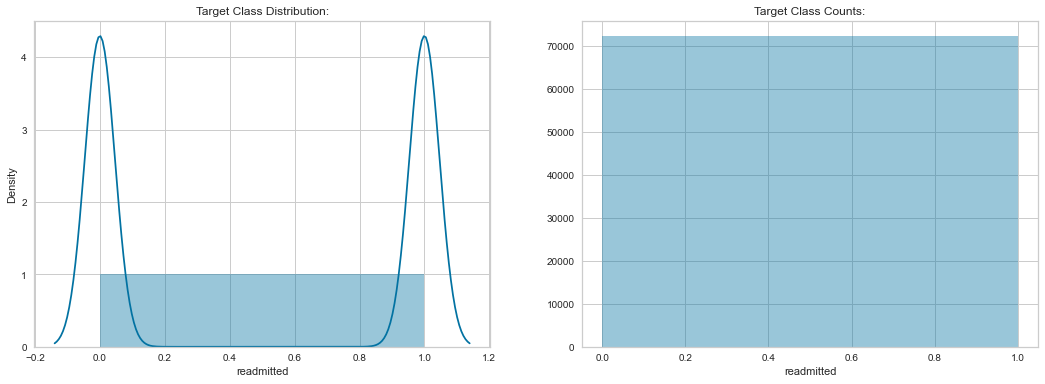

In [229]:
sm = SMOTE(random_state=1234)

X_sm, y_sm = sm.fit_resample(X_train, y_train)

plot_class_dist(y_sm)

#### Model building

In [230]:
model_scaled_l2_SMOTE = linear_model.LogisticRegressionCV(penalty="l2", solver='lbfgs', random_state=1234, cv=5)
model_scaled_l2_SMOTE = model_scaled_l2_SMOTE.fit(X_sm, y_sm)

In [231]:
model_scaled_l2_SMOTE.score(X_sm, y_sm)

0.6481624865193706

In [232]:
model_scaled_l2_SMOTE.scores_

{1: array([[0.62362172, 0.62427846, 0.62420933, 0.62486606, 0.62458954,
         0.62462411, 0.62465867, 0.62479693, 0.6247278 , 0.62469324],
        [0.64868135, 0.64774809, 0.64830113, 0.648232  , 0.64826657,
         0.64864678, 0.64850852, 0.64864678, 0.64861222, 0.64864678],
        [0.65164189, 0.65181473, 0.65250605, 0.65240235, 0.65309367,
         0.65305911, 0.65302454, 0.65316281, 0.65323194, 0.65319737],
        [0.64911856, 0.64942966, 0.64984445, 0.65001728, 0.65032838,
         0.65032838, 0.65039751, 0.65029381, 0.65032838, 0.65019011],
        [0.64849637, 0.6513308 , 0.65278258, 0.65302454, 0.65326651,
         0.65316281, 0.65309367, 0.65302454, 0.65305911, 0.65305911]])}

In [233]:
model_scaled_l2_SMOTE.C_

array([1291.54966501])

#### Best C is 1291.54966

In [234]:
model_scaled_l2_SMOTE = linear_model.LogisticRegressionCV(Cs=[1291.54966501], penalty="l2", solver='lbfgs', random_state=1234, max_iter=10000)
model_scaled_l2_SMOTE = model_scaled_l2_SMOTE.fit(X_sm, y_sm)

In [235]:
y_model_scaled_l2_SMOTE_predict = model_scaled_l2_SMOTE.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_model_scaled_l2_SMOTE_predict)
print('Logistic Regression Iteration 5 - Penalty L2, scaled and upsampled using SMOTE": ', accuracy)

Logistic Regression Iteration 5 - Penalty L2, scaled and upsampled using SMOTE":  0.6468998722609807


<font style="color:#ff0000;font-weight:600">Prediction accuracy for Logistic Regression Iteration 5 - Penalty L2, scaled and upsampled using SMOTE 64.7 % </font>

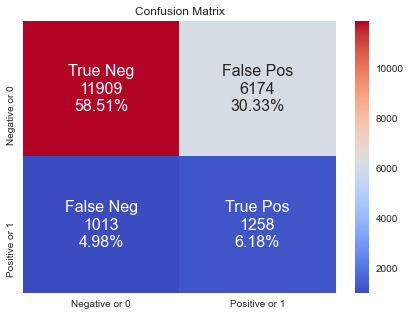

In [236]:
plot_confusion_matrix(y_test, y_model_scaled_l2_SMOTE_predict)

LR ROC: 0.606257673378635


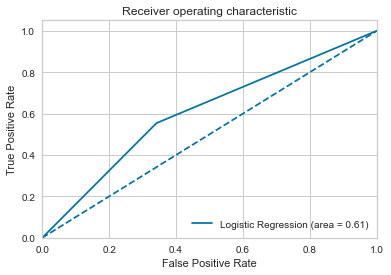

In [237]:
plot_roc_curve(y_test, y_model_scaled_l2_SMOTE_predict)

<br/>
<br/>
<br/>

<font style="color:#7B1FA2;font-weight:600;font-size:18px">Logistic Regression Iteration 4 - Penalty L2 and scaled and balanced considered to be best so far. We shall perform further analysis on this model</font>

#### Get important features 

In [242]:
#Creating a dictionary of the attributes and their coefficients 
coef_dict = {}
for coef, feat in zip(model_scaled_l2_balanced.coef_[0,:], X.columns):
    coef_dict[feat] = coef

In [243]:
#code adopted from: https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
coef_dict_sorted = {k: v for k, v in sorted(coef_dict.items(), key=lambda item: item[1])}

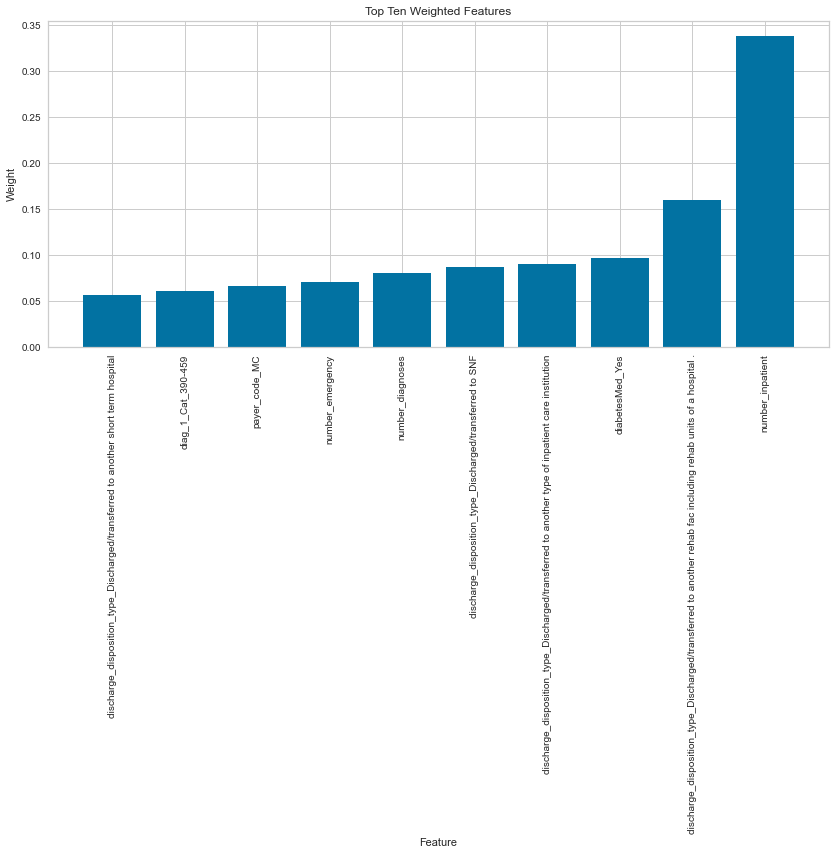

In [259]:
#https://stackoverflow.com/questions/7971618/python-return-first-n-keyvalue-pairs-from-dict
coef_top_ten = {k:coef_dict_sorted[k] for k in list(coef_dict_sorted)[-10:] }
fig = plt.figure()
plt.bar(coef_top_ten.keys(), coef_top_ten.values())
plt.xticks(rotation=90)
plt.title('Top Ten Weighted Features')
plt.xlabel('Feature')
plt.ylabel('Weight')
fig.set_figheight(6)
fig.set_figwidth(14)
plt.show()

In [248]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.from_dict.html

#Table to view the exact values
pd.DataFrame.from_dict(coef_top_ten, orient='index', columns=["Weight"])

,Weight
discharge_disposition_type_Discharged/transferred to another short term hospital,0.056123
diag_1_Cat_390-459,0.060200
payer_code_MC,0.066084
number_emergency,0.070931
number_diagnoses,0.079977
discharge_disposition_type_Discharged/transferred to SNF,0.087114
discharge_disposition_type_Discharged/transferred to another type of inpatient care institution,0.090289
diabetesMed_Yes,0.096378
discharge_disposition_type_Discharged/transferred to another rehab fac including rehab units of a hospital .,0.160224
number_inpatient,0.337948


### Interpretation

As we can see from isolating the ten attributes with the highest weights, 'number_of_inpatient' has the higest weight followed by 'discharge_disposition_type_Discharged/transferred to another rehab fac including rehab units of a hospital' and 'diabetesMed_Yes' etc.